# Домашнее задание к уроку 5: Аугментации и работа с изображениями

In [62]:
from augmentations_basics.datasets import CustomImageDataset
from augmentations_basics.utils import show_images, show_multiple_augmentations, show_single_augmentation

In [85]:
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

## Задание 1: Стандартные аугментации torchvision (15 баллов)

Создайте пайплайн стандартных аугментаций torchvision (например, RandomHorizontalFlip, RandomCrop, ColorJitter, RandomRotation, RandomGrayscale).
Примените аугментации к 5 изображениям из разных классов (папка train).
Визуализируйте:
Оригинал
Результат применения каждой аугментации отдельно
Результат применения всех аугментаций вместе

In [36]:
train_dir = "data/train"

In [32]:
import random
import torchvision.transforms as T

base_transform = T.ToTensor()
train_dataset = CustomImageDataset(root_dir=train_dir, transform=base_transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [38]:
samples = {}
for img, label in train_loader:
    label = label.item()
    if label not in samples:
        samples[label] = img[0]
    if len(samples) == 5:
        break

In [43]:
augmentations = {
    "RandomHorizontalFlip": T.Compose([T.RandomHorizontalFlip(p=1.0), T.ToTensor()]),
    "RandomResizedCrop": T.Compose([T.RandomResizedCrop(224), T.ToTensor()]),
    "ColorJitter": T.Compose([T.ColorJitter(brightness=0.5, contrast=0.5), T.ToTensor()]),
    "RandomRotation": T.Compose([T.RandomRotation(30), T.ToTensor()]),
    "RandomGrayscale": T.Compose([T.RandomGrayscale(p=1.0), T.ToTensor()]),
    "AllAug": T.Compose([
    T.RandomHorizontalFlip(p=1.0),
    T.RandomResizedCrop(224),
    T.ColorJitter(brightness=0.5, contrast=0.5),
    T.RandomRotation(30),
    T.RandomGrayscale(p=1.0),
    T.ToTensor()
])
}

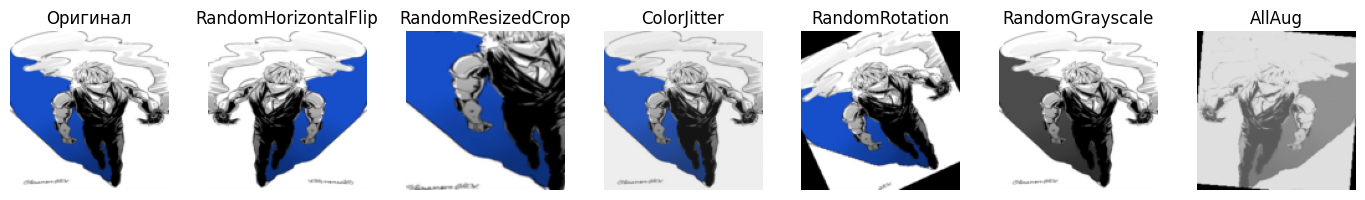

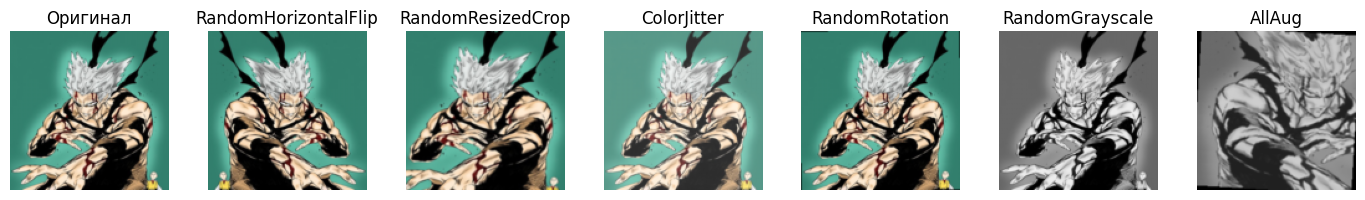

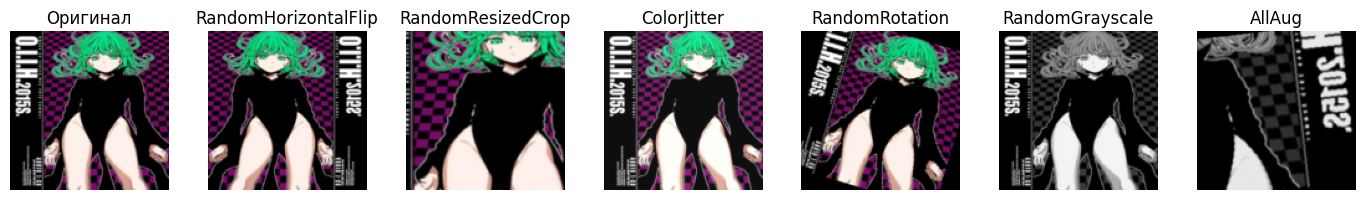

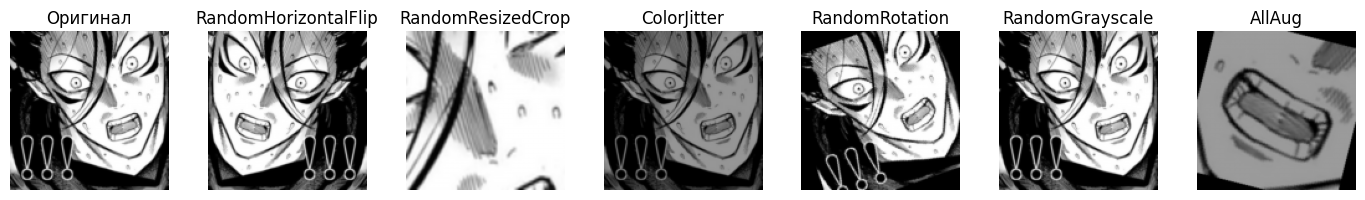

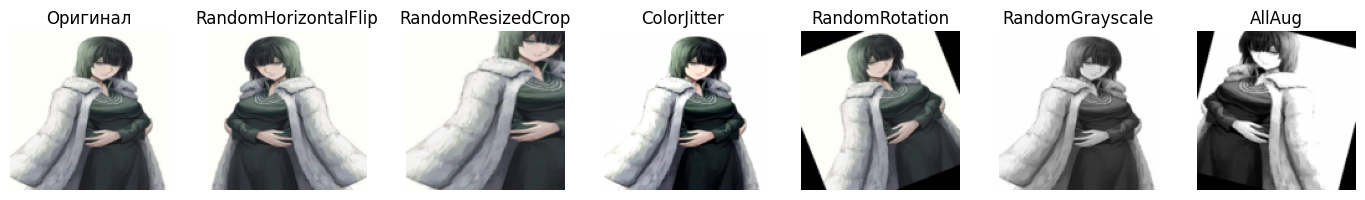

In [ ]:
for label, image in samples.items():
    pil_img = T.ToPILImage()(image)

    augmented_imgs = []
    titles = []

    for name, transform in augmentations.items():
        aug_img = transform(pil_img)
        augmented_imgs.append(aug_img)
        titles.append(name)
    
    show_multiple_augmentations(image, augmented_imgs, titles)


# Задание 2: Кастомные аугментации (20 баллов)

Реализуйте минимум 3 кастомные аугментации (например, случайное размытие, случайная перспектива, случайная яркость/контрастность).
Примените их к изображениям из train.
Сравните визуально с готовыми аугментациями из extra_augs.py.

In [65]:
from PIL import Image, ImageEnhance, ImageFilter

# 1. Случайное размытие
class RandomBlur:
    def __init__(self, p=0.5, radius=2):
        self.p = p
        self.radius = radius

    def __call__(self, img):
        if random.random() < self.p:
            return img.filter(ImageFilter.GaussianBlur(self.radius))
        return img

# 2. Случайная перспектива
class RandomPerspective:
    def __init__(self, distortion_scale=0.5, p=0.5):
        self.p = p
        self.distortion_scale = distortion_scale

    def __call__(self, img):
        if random.random() < self.p:
            width, height = img.size
            startpoints = [
                [0, 0], [width, 0], [width, height], [0, height]
            ]
            endpoint_noise = lambda: random.uniform(-self.distortion_scale * width, self.distortion_scale * width)
            endpoints = [[x + endpoint_noise(), y + endpoint_noise()] for x, y in startpoints]
            return T.functional.perspective(img, startpoints, endpoints, interpolation=Image.BICUBIC)
        return img

# 3. Случайная яркость и контраст
class RandomBrightnessContrast:
    def __init__(self, brightness=0.5, contrast=0.5, p=0.5):
        self.brightness = brightness
        self.contrast = contrast
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(1 + (random.random() - 0.5) * 2 * self.brightness)
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(1 + (random.random() - 0.5) * 2 * self.contrast)
        return img


In [46]:
custom_augs = {
    "RandomBlur": T.Compose([RandomBlur(p=1.0), T.ToTensor()]),
    "RandomPerspective": T.Compose([RandomPerspective(p=1.0), T.ToTensor()]),
    "RandomBrightnessContrast": T.Compose([RandomBrightnessContrast(p=1.0), T.ToTensor()])
}

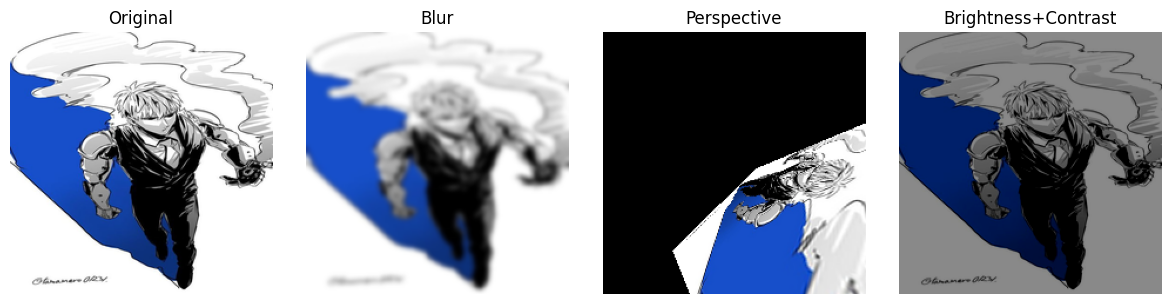

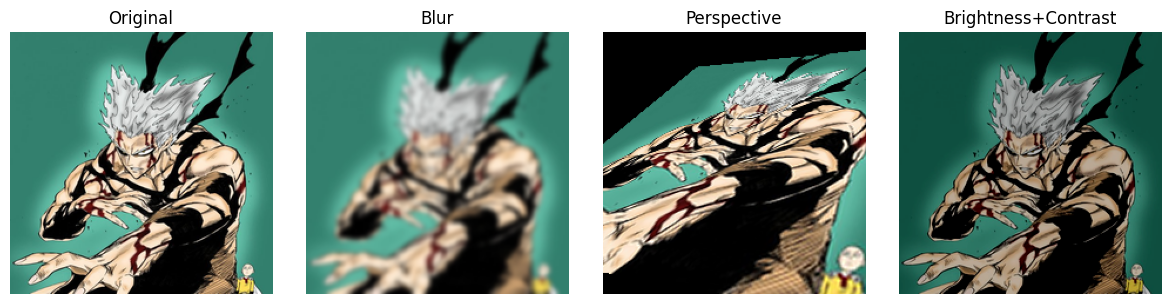

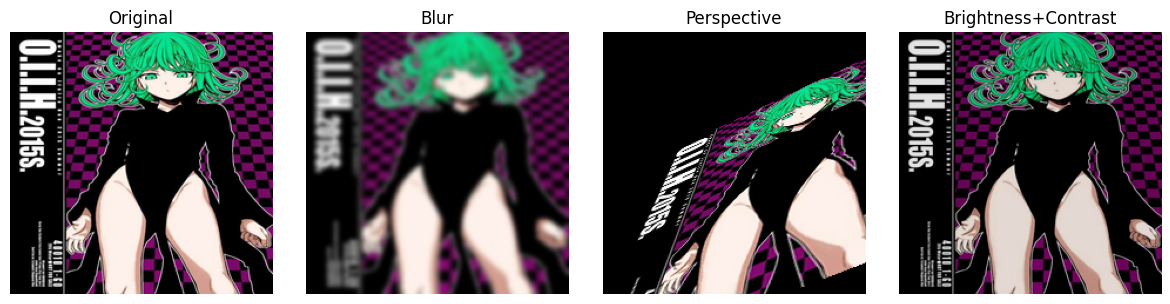

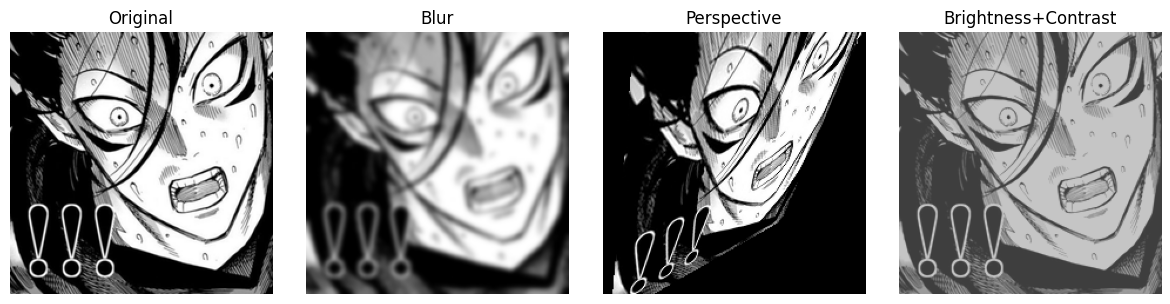

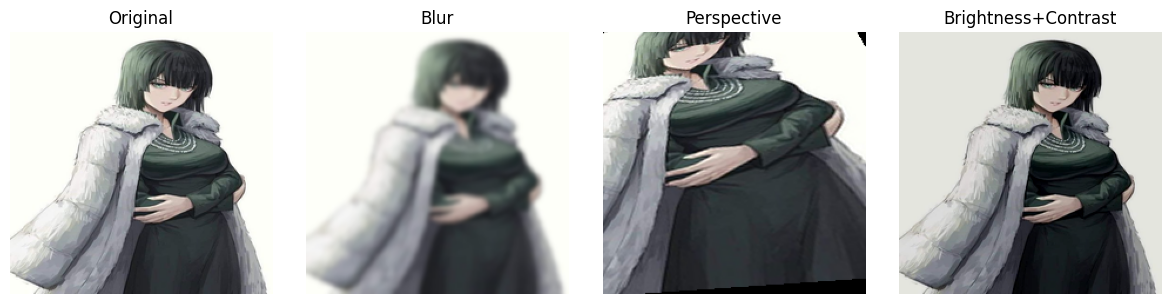

In [66]:
to_pil = T.ToPILImage()
to_tensor = T.ToTensor()

for label, img_tensor in samples.items():
    pil_img = to_pil(img_tensor)

    aug_blur = custom_augs["RandomBlur"](pil_img)
    aug_persp = custom_augs["RandomPerspective"](pil_img)
    aug_bc = custom_augs["RandomBrightnessContrast"](pil_img)

    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    imgs = [pil_img, T.ToPILImage()(aug_blur), T.ToPILImage()(aug_persp), T.ToPILImage()(aug_bc)]
    titles = ["Original", "Blur", "Perspective", "Brightness+Contrast"]

    for ax, img, title in zip(axs, imgs, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Задание 3: Анализ датасета (10 баллов)

Подсчитайте количество изображений в каждом классе.
Найдите минимальный, максимальный и средний размеры изображений.
Визуализируйте распределение размеров и гистограмму по классам.

In [67]:
from collections import defaultdict
import os


class_counts = defaultdict(int)
image_sizes = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    image_sizes.append((width, height))
                    class_counts[class_name] += 1
            except Exception as e:
                print(f"Ошибка при чтении {img_path}: {e}")

In [68]:
print("Количество изображений по классам:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Количество изображений по классам:
Гароу: 30
Генос: 30
Сайтама: 30
Соник: 30
Татсумаки: 30
Фубуки: 30


In [70]:
widths = [w for w, h in image_sizes]
heights = [h for w, h in image_sizes]
min_size = (min(widths), min(heights))
max_size = (max(widths), max(heights))
avg_size = (sum(widths)/len(widths), sum(heights)/len(heights))

print(f"Минимальный размер изображения: {min_size}")
print(f"Максимальный размер изображения: {max_size}")
print(f"Средний размер изображения: {avg_size[0]:.1f} x {avg_size[1]:.1f}")

Минимальный размер изображения: (210, 240)
Максимальный размер изображения: (736, 1308)
Средний размер изображения: 538.9 x 623.6


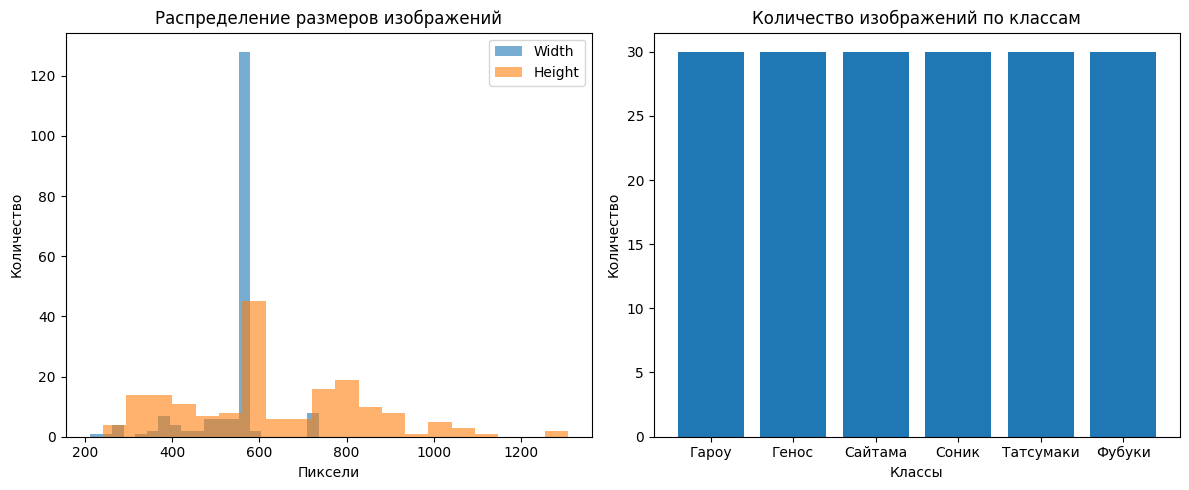

In [71]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, alpha=0.6, label='Width')
plt.hist(heights, bins=20, alpha=0.6, label='Height')
plt.title("Распределение размеров изображений")
plt.xlabel("Пиксели")
plt.ylabel("Количество")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Количество изображений по классам")
plt.xlabel("Классы")
plt.ylabel("Количество")

plt.tight_layout()
plt.show()

## Задание 4: Pipeline аугментаций (20 баллов)

1. Реализуйте класс AugmentationPipeline с методами:
   - add_augmentation(name, aug)
   - remove_augmentation(name)
   - apply(image)
   - get_augmentations()
2. Создайте несколько конфигураций (light, medium, heavy).
3. Примените каждую конфигурацию к train и сохраните результаты.

In [73]:
class AugmentationPipeline:
    def __init__(self):
        self.augmentations = {}

    def add_augmentation(self, name, aug):
        self.augmentations[name] = aug

    def remove_augmentation(self, name):
        if name in self.augmentations:
            del self.augmentations[name]

    def get_augmentations(self):
        return list(self.augmentations.keys())

    def apply(self, image):
        for aug in self.augmentations.values():
            image = aug(image)
        return image


In [79]:
def ensure_dirs(base_dir, class_names):
    for config in ["light", "medium", "heavy"]:
        for cls in class_names:
            os.makedirs(os.path.join(base_dir, config, cls), exist_ok=True)

In [80]:
light_pipeline = AugmentationPipeline()
light_pipeline.add_augmentation("color_jitter", T.ColorJitter(brightness=0.2, contrast=0.2))

medium_pipeline = AugmentationPipeline()
medium_pipeline.add_augmentation("flip", T.RandomHorizontalFlip(p=1.0))
medium_pipeline.add_augmentation("rotate", T.RandomRotation(25))
medium_pipeline.add_augmentation("jitter", T.ColorJitter(brightness=0.3, contrast=0.3))

heavy_pipeline = AugmentationPipeline()
heavy_pipeline.add_augmentation("flip", T.RandomHorizontalFlip(p=1.0))
heavy_pipeline.add_augmentation("rotate", T.RandomRotation(25))
heavy_pipeline.add_augmentation("jitter", T.ColorJitter(brightness=0.3, contrast=0.3))
heavy_pipeline.add_augmentation("perspective", T.RandomPerspective(distortion_scale=0.5, p=1.0))
heavy_pipeline.add_augmentation("blur", T.GaussianBlur(kernel_size=5))

In [ ]:
pipelines = {
    "light": light_pipeline,
    "medium": medium_pipeline,
    "heavy": heavy_pipeline
}

class_names = train_dataset.get_class_names()
ensure_dirs("augmented_results", class_names)

In [83]:
from tqdm import tqdm

for idx, (img, label) in enumerate(tqdm(train_loader)):
    label_idx = label.item()
    label_name = class_names[label_idx]
    
    pil_img = T.ToPILImage()(img[0])
    
    for name, pipeline in pipelines.items():
        augmented = pipeline.apply(pil_img)
        save_path = os.path.join("augmented_results", name, label_name, f"{idx}.jpg")
        augmented.save(save_path)

100%|██████████| 180/180 [00:04<00:00, 40.99it/s]


# Задание 5: Эксперимент с размерами (10 баллов)

Проведите эксперимент с разными размерами изображений (например, 64x64, 128x128, 224x224, 512x512).
Для каждого размера измерьте время загрузки и применения аугментаций к 100 изображениям, а также потребление памяти.
Постройте графики зависимости времени и памяти от размера.

In [132]:
import time
import psutil
from memory_profiler import memory_usage

sizes = [64, 128, 224, 512]

In [102]:
image_paths = []
for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(class_path, file))

random.shuffle(image_paths)
image_paths = image_paths[:100]

In [103]:
base_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.ColorJitter(brightness=0.5, contrast=0.5),
])

In [150]:
import tracemalloc

def process_images_accumulate(image_paths, resize_size, transform):
    results = []
    for path in image_paths:
        img = Image.open(path).convert("RGB")
        img = img.resize((resize_size, resize_size))
        img_tensor = transform(T.ToTensor()(img))
        results.append(img_tensor)
    return results


def measure_time_and_memory(image_paths, resize_size, transform):
    tracemalloc.start()
    start_time = time.time()
    _ = process_images_accumulate(image_paths, resize_size, transform)
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    duration = end_time - start_time
    peak_memory_mb = peak / 1024 / 1024
    return duration, peak_memory_mb

In [151]:
times = []
memories = []

for size in sizes:
    t, m = measure_time_and_memory(image_paths, size, base_transform)
    times.append(t)
    memories.append(m)
    print(f"{size}x{size}: {t:.2f} сек, {m:.2f} MB")

64x64: 0.97 сек, 0.17 MB
128x128: 1.13 сек, 0.16 MB
224x224: 1.44 сек, 0.30 MB
512x512: 2.64 сек, 1.52 MB


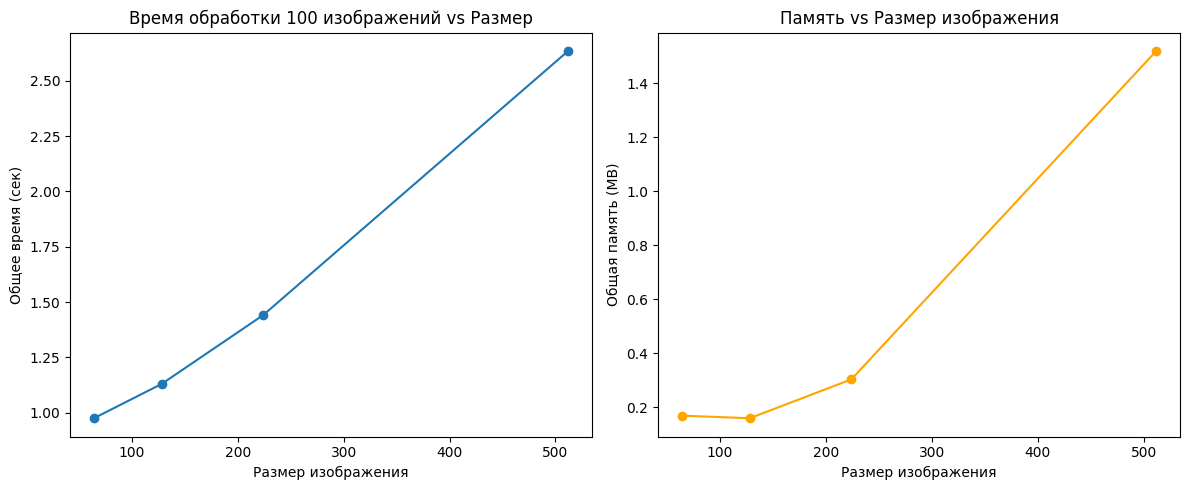

In [152]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sizes, times, marker='o')
plt.title("Время обработки 100 изображений vs Размер")
plt.xlabel("Размер изображения")
plt.ylabel("Общее время (сек)")

plt.subplot(1, 2, 2)
plt.plot(sizes, memories, marker='o', color='orange')
plt.title("Память vs Размер изображения")
plt.xlabel("Размер изображения")
plt.ylabel("Общая память (MB)")

plt.tight_layout()
plt.show()

# Задание 6: Дообучение предобученных моделей (25 баллов)

Возьмите одну из предобученных моделей torchvision (например, resnet18, efficientnet_b0, mobilenet_v3_small).
Замените последний слой на количество классов вашего датасета.
Дообучите модель на train, проверьте качество на val.
Визуализируйте процесс обучения (loss/accuracy).

In [118]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [119]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = CustomImageDataset('data/train', transform=transform)
test_dataset = CustomImageDataset('data/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [153]:
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.get_class_names()))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [125]:
from trainer import train_model

results = train_model(model, train_loader, test_loader, epochs=15, lr=0.001, device=device)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Epoch 1/15:
Train Loss: 0.4834, Train Acc: 0.8722
Test Loss: 1.9851, Test Acc: 0.6050
--------------------------------------------------


100%|██████████| 19/19 [00:07<00:00,  2.71it/s]


Epoch 2/15:
Train Loss: 0.6869, Train Acc: 0.8000
Test Loss: 3.5221, Test Acc: 0.5500
--------------------------------------------------


100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


Epoch 3/15:
Train Loss: 0.3101, Train Acc: 0.9222
Test Loss: 1.5838, Test Acc: 0.6117
--------------------------------------------------


100%|██████████| 19/19 [00:08<00:00,  2.35it/s]


Epoch 4/15:
Train Loss: 0.2717, Train Acc: 0.9000
Test Loss: 1.1281, Test Acc: 0.6967
--------------------------------------------------


100%|██████████| 19/19 [00:07<00:00,  2.38it/s]


Epoch 5/15:
Train Loss: 0.1976, Train Acc: 0.9500
Test Loss: 2.9382, Test Acc: 0.5667
--------------------------------------------------


100%|██████████| 19/19 [00:07<00:00,  2.50it/s]


Epoch 6/15:
Train Loss: 0.1853, Train Acc: 0.9278
Test Loss: 2.1959, Test Acc: 0.6217
--------------------------------------------------


100%|██████████| 19/19 [00:07<00:00,  2.64it/s]


Epoch 7/15:
Train Loss: 0.1404, Train Acc: 0.9667
Test Loss: 3.3822, Test Acc: 0.5150
--------------------------------------------------


100%|██████████| 19/19 [00:07<00:00,  2.70it/s]


Epoch 8/15:
Train Loss: 0.0901, Train Acc: 0.9722
Test Loss: 1.0810, Test Acc: 0.7317
--------------------------------------------------


100%|██████████| 19/19 [00:07<00:00,  2.66it/s]


Epoch 9/15:
Train Loss: 0.0476, Train Acc: 0.9778
Test Loss: 1.0342, Test Acc: 0.7300
--------------------------------------------------


100%|██████████| 19/19 [00:07<00:00,  2.62it/s]


Epoch 10/15:
Train Loss: 0.0648, Train Acc: 0.9889
Test Loss: 0.5792, Test Acc: 0.8167
--------------------------------------------------


100%|██████████| 19/19 [00:06<00:00,  2.80it/s]


Epoch 11/15:
Train Loss: 0.0444, Train Acc: 0.9833
Test Loss: 0.4321, Test Acc: 0.8700
--------------------------------------------------


100%|██████████| 19/19 [00:07<00:00,  2.71it/s]


Epoch 12/15:
Train Loss: 0.0090, Train Acc: 1.0000
Test Loss: 0.4180, Test Acc: 0.8800
--------------------------------------------------


100%|██████████| 19/19 [00:07<00:00,  2.64it/s]


Epoch 13/15:
Train Loss: 0.0336, Train Acc: 0.9889
Test Loss: 0.4290, Test Acc: 0.8550
--------------------------------------------------


100%|██████████| 19/19 [00:07<00:00,  2.52it/s]


Epoch 14/15:
Train Loss: 0.0280, Train Acc: 0.9889
Test Loss: 0.4909, Test Acc: 0.8317
--------------------------------------------------


100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

Epoch 15/15:
Train Loss: 0.0238, Train Acc: 0.9944
Test Loss: 0.5983, Test Acc: 0.8317
--------------------------------------------------


In [ ]:
def plot_training_results(results):
    epochs = range(1, len(results['train_losses']) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, results['train_losses'], label='Train Loss')
    plt.plot(epochs, results['test_losses'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, results['train_accs'], label='Train Accuracy')
    plt.plot(epochs, results['test_accs'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

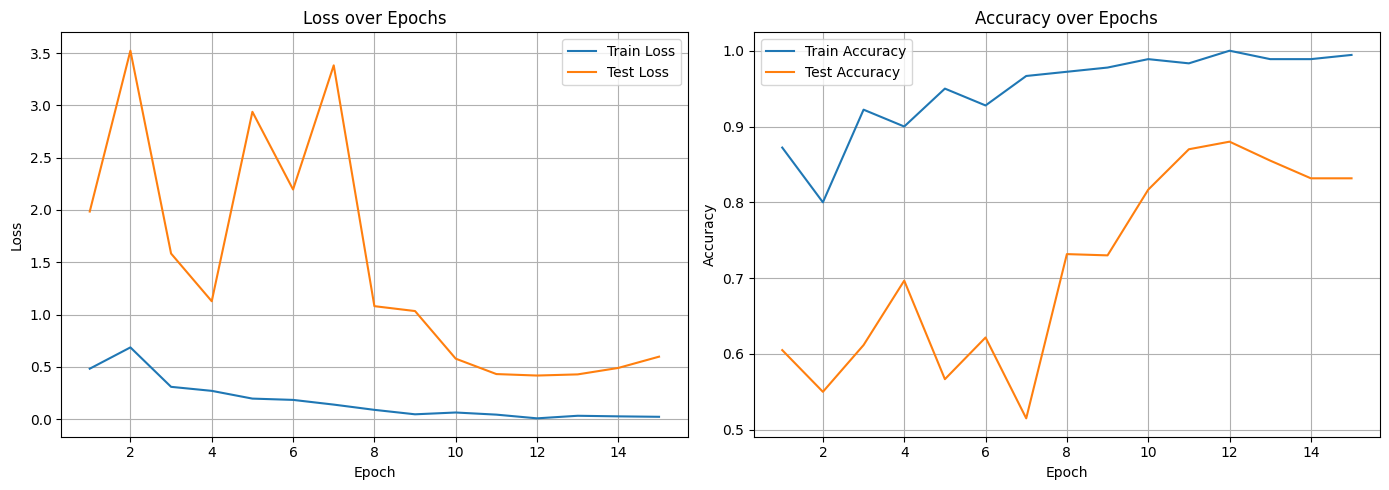

In [127]:
plot_training_results(results)